In [1]:
import numpy as np
import pandas as pd

<Axes: >

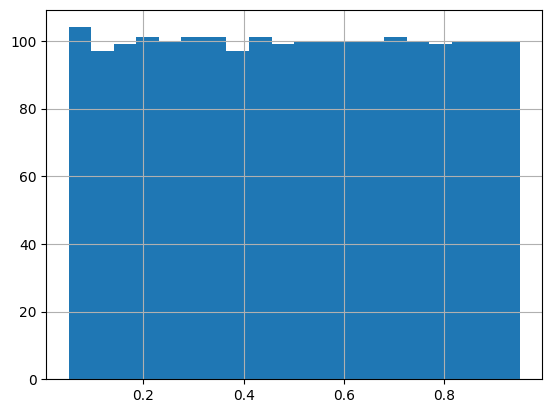

In [59]:
def simulate_with_target_ate(
    n=5000,
    min_ate=0.00,
    max_ate=1.00,
    max_attempts=1000,
    coef_ranges=None,
    intercept_ranges=None,
    noise_std=0.5
):
    """
    Simulates data for binary treatment effect analysis.
    Fixes clustering by:
    - Using continuous U ~ N(0,1)
    - Adding Gaussian noise to logits

    Returns dict with true ATE and all coefficients.
    """
    if coef_ranges is None:
        coef_ranges = {
            'b_Z': (0.0, 3.0),
            'b_U_X': (0.0, 3.0),
            'b_X_Y': (0.0, 20.0),
            'b_U_Y': (0.0, 3.0)
        }
    if intercept_ranges is None:
        intercept_ranges = {
            'intercept_X': (-4.0, 4.0),
            'intercept_Y': (-4.0, 4.0)
        }

    for attempt in range(max_attempts):
        seed = np.random.randint(0, 1e6)
        np.random.seed(seed)

        # Coefficients
        b_Z = np.random.uniform(*coef_ranges['b_Z'])
        b_U_X = np.random.uniform(*coef_ranges['b_U_X'])
        b_X_Y = np.random.uniform(*coef_ranges['b_X_Y'])
        b_U_Y = np.random.uniform(*coef_ranges['b_U_Y'])

        intercept_X = np.random.uniform(*intercept_ranges['intercept_X'])
        intercept_Y = np.random.uniform(*intercept_ranges['intercept_Y'])

        # Generate continuous latent confounder
        Z = np.random.binomial(1, 0.5, size=n)
        U = np.random.normal(0, 1, size=n)

        # Generate treatment X
        logit_X = intercept_X + b_Z * Z + b_U_X * U
        p_X = 1 / (1 + np.exp(-logit_X))
        X = np.random.binomial(1, p_X)

        # Generate outcome Y with noise
        logit_Y = intercept_Y + b_X_Y * X + b_U_Y * U + np.random.normal(0, noise_std, size=n)
        p_Y = 1 / (1 + np.exp(-logit_Y))
        Y = np.random.binomial(1, p_Y)

        # Counterfactual outcomes with same noise structure
        logit_Y1 = intercept_Y + b_X_Y * 1 + b_U_Y * U + np.random.normal(0, noise_std, size=n)
        logit_Y0 = intercept_Y + b_X_Y * 0 + b_U_Y * U + np.random.normal(0, noise_std, size=n)
        p_Y1 = 1 / (1 + np.exp(-logit_Y1))
        p_Y0 = 1 / (1 + np.exp(-logit_Y0))
        ATE_true = np.mean(p_Y1 - p_Y0)

        if min_ate <= ATE_true <= max_ate:
            return {
                'seed': seed,
                'b_Z': b_Z,
                'b_U_X': b_U_X,
                'b_X_Y': b_X_Y,
                'b_U_Y': b_U_Y,
                'intercept_X': intercept_X,
                'intercept_Y': intercept_Y,
                'ATE_true': ATE_true,
                'Z': Z,
                'U': U,
                'X': X,
                'Y': Y
            }

    raise ValueError(f"Failed to generate ATE in range [{min_ate}, {max_ate}] after {max_attempts} attempts")

def simulate_uniform_ate_distribution(
    n=5000,
    n_bins=10,
    samples_per_bin=50,
    bin_range=(0.05, 0.95),
    simulate_kwargs=None,
    max_attempts=30000,
    verbose=True
):
    if simulate_kwargs is None:
        simulate_kwargs = {}

    bins = np.linspace(*bin_range, n_bins + 1)
    bin_counts = np.zeros(n_bins, dtype=int)
    data = []

    attempts = 0
    total_required = n_bins * samples_per_bin

    while sum(bin_counts) < total_required and attempts < max_attempts:
        sim = simulate_with_target_ate(n=n, min_ate=bin_range[0], max_ate=bin_range[1], **simulate_kwargs)
        ate = sim["ATE_true"]
        bin_idx = np.digitize(ate, bins) - 1

        if 0 <= bin_idx < n_bins and bin_counts[bin_idx] < samples_per_bin:
            bin_counts[bin_idx] += 1
            data.append(sim)

        attempts += 1

    if attempts >= max_attempts and sum(bin_counts) < total_required:
        print(f"⚠️ Warning: Only filled {sum(bin_counts)} / {total_required} samples after {attempts} attempts.")
        if verbose:
            for i in range(n_bins):
                print(f"  Bin {i} ({bins[i]:.2f}-{bins[i+1]:.2f}): {bin_counts[i]} samples")

    return data




sim_data = simulate_uniform_ate_distribution(
    n=5000,
    n_bins=20,
    samples_per_bin=100,
    simulate_kwargs={'noise_std': 1.0},  # more variation!
    verbose=True
)

df_uniform = pd.DataFrame(sim_data)
df_uniform.ATE_true.hist(bins=20)


,ATE_true
count,2000.000000
mean,0.499764
std,0.259858
min,0.050550
25%,0.274889
50%,0.499948
75%,0.724690
max,0.949893


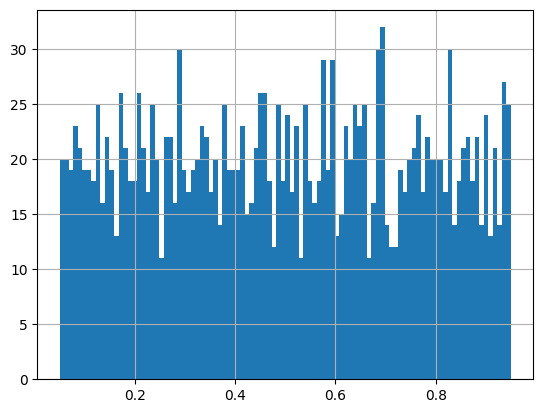

In [41]:
df_uniform.ATE_true.hist(bins=100)
df_uniform.ATE_true.describe()


<ipython-input-57-27ca2d4d3dc9>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("bin")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   seed         1100 non-null   int64  
 1   b_Z          1100 non-null   float64
 2   b_U_X        1100 non-null   float64
 3   b_X_Y        1100 non-null   float64
 4   b_U_Y        1100 non-null   float64
 5   intercept_X  1100 non-null   float64
 6   intercept_Y  1100 non-null   float64
 7   ATE_true     1100 non-null   float64
 8   Z            1100 non-null   object 
 9   U            1100 non-null   object 
 10  X            1100 non-null   object 
 11  Y            1100 non-null   object 
dtypes: float64(7), int64(1), object(4)
memory usage: 103.3+ KB


<ipython-input-57-27ca2d4d3dc9>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min_count, random_state=42))


array([0, 0, 1, ..., 0, 1, 1])

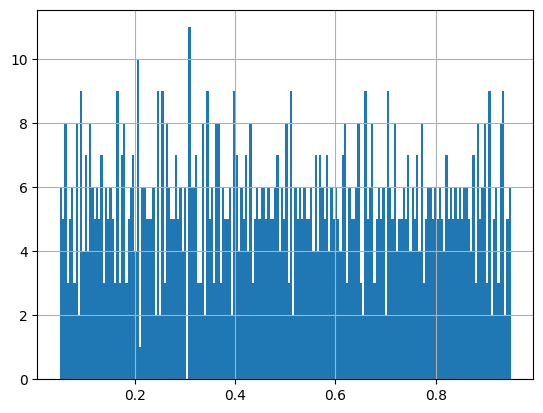

In [57]:
def trim_to_min_per_bin(df, col='ATE_true', n_bins=20, verbose=True):
    """
    Trims samples in each bin to match the bin with the fewest samples.
    Ensures a flat histogram across bins.
    """
    # Create bins
    bins = np.linspace(df[col].min(), df[col].max(), n_bins + 1)
    df["bin"] = pd.cut(df[col], bins=bins, include_lowest=True)

    # Count samples per bin
    bin_counts = df["bin"].value_counts().sort_index()
    min_count = bin_counts.min()

    if verbose:
        print(f"Minimum bin count: {min_count}")
        print(bin_counts)

    # Sample min_count from each bin
    trimmed_df = (
        df.groupby("bin")
        .apply(lambda g: g.sample(n=min_count, random_state=42))
        .reset_index(drop=True)
        .drop(columns=["bin"])
    )
    return trimmed_df

df_flat = trim_to_min_per_bin(df_uniform, col='ATE_true', n_bins=100, verbose=False)
df_flat.ATE_true.hist(bins=200)
df_flat.info()
df_flat.Z.iloc[1]



In [58]:
df_flat.to_pickle("synthetic_ate_dataset.pkl")
